# Evaluation on A9 Dataset

The basis for these evaluations are the saved detections for each model. In productive use, the model output is directly used and some calculations are performed on the GPU, however the algorithm is equal. The results might only differ due to rounding errors and alike.

The results might not be exactly like in my thesis because the generation of training- and test set is random.

Frames are split into training and test set, such that they have a similar distribution of number of labels and camers. The training set (~1/4 of frames) frames is used to calculate the optimal hyperparameters. The ratio does not need to be high and therefore more frames are included in the test set which improves the evaluation. With the optimized hyperparameters, the approach will be evaluated on the test set. The hyperparameters are optimized for each instance segmentation model individually and the results on the test can can be compared. 

## Metrics

At first, corresponding predictions and labels have to be matched (to compare location and dimensions later on). This works as follows:
1. Calculate pairwise distances between labels and predictions on image
2. Match pairs if they are both their nearest neighbor
3. Remove unmatched labels, unmatched predictions, and matches with labels further away than the distance cutoff

The cutoff is needed because the frames contain vehicles too far away for labeling and detecting. Therefore, it is also dependent on the perspective. The pairs are matched first to not count e.g. a label, slightly within the cutoff, as unmatched if the corresponding prediction is slightly outside. In productive use, the predictions to far awaycan just be ignored.

After matching, precision, recall and F1 score can be calculated (micro average) with matches as true positives (*TP*), unmachted labels as false negatives (*FN*), and unmatched predictions as false positives (*FP*).

$$precision = \frac{TP}{TP + FP}$$
$$recall = \frac{TP}{TP + FN}$$
$$f1 = 2* \frac{precision * recall}{precision + recall}$$

The matched pairs can be used to calculate the mean average error (*MAE*) for location and dimensions. The differences in predicted and labeled categories can be evaluated using a confusion matrix.

$$ MAE = \frac{1}{n} \sum_{i}^n |\hat{y}_i - y_i| $$

## Optimal Hyperparameters

The hyperparameters are:
1. score threshold (for scores of results of instance segmentation)
2. mask width threshold (for approximated widths of instance masks)
3. image margin threshold (for minimum distances of instance masks to image edge)
4. vehicle dimensions (min, max, and mean of length, width, and height for each vehicle category)
5. vertical contour shift (number of pixels contours are shifted down on image)


First, the vehicle dimensions can be calculated, including the alignment of heights for better distinction between cars, vans, and trucks. Then, thresholds 1 and 2 are evaluated on the f1 score. The image margin threshold can be set to zero since it only exists to not make predictions on cutoff vehicles. At last, the vertical contour shift can be optimized based on location- and dimenisions errors.

## Test Set Evaluation

For every instance segmentation model, with the individually optimal hyperparameters, the test set can be formally evaluated on precision, recall, f1 score, location error, dimensions error, and category error. These values are split per label category, perspective, and distance to camera.

## Qualitative Results

Show predictions and labels on frames and 2D views inclusing common false positives and false negatives.




In [34]:
# Allows import from parent directory.
import sys; sys.path.append('..')

import os
from typing import Dict, Iterator, List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.io as pio
import src.visualization_utils as viz
from mpl_toolkits.axes_grid1 import ImageGrid
from plotly.subplots import make_subplots
from src.approaches.fixed_angle import create_predictions
from src.loaders import DetectionsLoader, FrameLoader, LabelsLoader
from src.models import DirectionLine, Vehicle
from src.perspective import Perspective
from src.providentia_utils import (
    extract_camera_name,
    match_perspective,
    parse_perspectives,
)

pio.templates['tight'] = dict(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        font=dict(family='charter', color='black', size=14),
    )
)
pio.templates.default = 'plotly_white+tight'


In [2]:
# Labels, frames, and perspectives for A9 dataset
labels_loader = LabelsLoader('../data/r0_a9_dataset/labels_fixed')
frame_loader = FrameLoader('../data/r0_a9_dataset/images')
perspectives = parse_perspectives('../data/profusion_r0_dataset/r0_s1/05_calibration')

# Detections lodader for every model
detections_dir_path = '../data/detections/r0_a9_dataset'
detections_loaders = {
    name: DetectionsLoader(os.path.join(detections_dir_path, name))
    for name in sorted(os.listdir(detections_dir_path))
}

# Different cutoff based on perspective
cutoffs = {
    perspective: 250 if '50mm' in camera else 125
    for camera, perspective in perspectives.items()
}

# Fixed parameters
direction_line = DirectionLine(np.array([[0, 1]]).T, 0)
label_mappings = {
    'coco': {2: 'CAR', 5: 'BUS', 7: 'TRUCK'},
}

output_dir = 'output/fixed_angle'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Split frames into training and test with 1/4 ratio
split_ratio = 1 / 4

# Create dataframe for camera and number of labels per frame.
data = {
    'camera': [],
    'labels': [],
}
for labels, labels_data in labels_loader.load_items():
    camera = extract_camera_name(labels_data)
    data['camera'].append(camera)
    data['labels'].append(len(labels))
frames_df = pd.DataFrame(data)

# Create split.
split = None
split_path = os.path.join(output_dir, 'split.npy')
if os.path.exists(split_path):
    split = np.load(split_path)

if split is None:
    split = np.zeros(len(frames_df), dtype=bool)
    for camera, part in frames_df.camera.value_counts().items():
        num_frames_to_sample = round(part * split_ratio)
        selected_camera_frames = np.random.choice(
            frames_df[frames_df.camera == camera].index,
            size=num_frames_to_sample,
            replace=False,
        )
        split[selected_camera_frames] = True
np.save(split_path, split)

frames_df['split'] = split

training_indices = np.argwhere(split).squeeze()
test_indices = np.argwhere(~split).squeeze()

# Compare distributions on frames per camera and mean number of labels per camera.
df = frames_df.groupby(['camera', 'split']).count().reset_index()
df.loc[df.split, 'labels'] /= df[df.split].labels.sum()
df.loc[~df.split, 'labels'] /= df[~df.split].labels.sum()
px.bar(
    df,
    x='camera',
    y='labels',
    color='split',
    barmode='group',
    labels={'labels': 'percentage of labels'},
    height=200,
).show()
px.bar(
    frames_df.groupby(['camera', 'split']).mean().reset_index(),
    x='camera',
    y='labels',
    color='split',
    barmode='group',
    labels={'labels': 'mean number of labels'},
    height=200,
).show()

In [4]:
def produce_dimension_values_mapping(
    labels_loader: LabelsLoader,
    frame_indices: Iterator[int],
    category_merges: Dict[str, str] = {'TRAILER': 'TRUCK'},
    wanted_categories: Set[str] = {'CAR', 'VAN', 'BUS', 'TRUCK'},
    height_partitions: List[List[str]] = [['CAR'], ['VAN'], ['BUS', 'TRUCK']],
) -> Dict[str, Tuple]:
    """
    Produce min-, mean-, and max values for each dimension per wanted category.
    Also partition height values based on averaged mean values between neigbors.
    """

    # Aggregate data for all labels.
    data = {'category': [], 'length': [], 'width': [], 'height': []}
    for labels, _ in labels_loader.load_items(frame_indices):
        for label in labels:
            # Combine trailers and trucks.
            if label.category in category_merges:
                label.category = category_merges[label.category]

            if label.category not in wanted_categories:
                continue

            length, width, height = label.dimensions
            data['length'].append(length)
            data['width'].append(width)
            data['height'].append(height)
            data['category'].append(label.category)

    labels_df = pd.DataFrame(data)

    # Create min-, mean-, and max values for each dimension per category.
    category_group = labels_df[['length', 'width', 'height']].groupby(
        labels_df.category
    )
    quantiles = category_group.quantile([0.02, 0.98])
    means = category_group.mean()

    mapping = {}
    for category in labels_df.category.unique():
        lower, higher = quantiles.loc[category].values
        mean = means.loc[category].values
        mapping[category] = np.array([lower, mean, higher]).T.tolist()

    # Partition heights based on average of neighbor means.
    height_means = [
        sum(mapping[c][2][1] for c in cats) / len(cats) for cats in height_partitions
    ]
    boundaries = [(a + b) / 2 for a, b in zip(height_means, height_means[1:])]

    for max_cats, min_cats, boundary in zip(
        height_partitions, height_partitions[1:], boundaries
    ):
        for c in max_cats:
            mapping[c][2][2] = boundary
        for c in min_cats:
            mapping[c][2][0] = boundary

    return mapping

In [5]:
dimension_values_mapping = produce_dimension_values_mapping(labels_loader, training_indices)
dimension_values_mapping

{'VAN': [[4.099999981701286, 5.803020170411087, 7.450631444720269],
  [1.6687146350593711, 2.0623098554809847, 2.5134531049684177],
  [1.8183328111364123, 2.183872053872054, 2.825050516846341]],
 'CAR': [[3.3299998872421135, 4.599699245286215, 4.8787864136661625],
  [1.5699999991084406, 1.9472275468955105, 2.16648129012679],
  [1.22, 1.4527935684007707, 1.8183328111364123]],
 'TRUCK': [[2.5727330268108317, 9.302865710457676, 16.717041507282246],
  [2.0087642629233406, 2.518631572683383, 2.9214343617273095],
  [2.825050516846341, 3.600582959641256, 4.210999999999999]],
 'BUS': [[10.292000169266652, 13.265532311806298, 17.597707296234123],
  [2.4984397203254343, 2.596673492356491, 2.807874819194559],
  [2.825050516846341, 3.331875, 3.931]]}

In [6]:
def calculate_image_centers(
    vehicles: List[Vehicle], perspective: Perspective
) -> np.ndarray:
    """Project vehicle centers (ground location + height/2) into image plane."""

    centers = np.hstack(
        [
            vehicle.location + np.array([[0, 0, vehicle.dimensions[2] / 2]]).T
            for vehicle in vehicles
        ]
    )
    centers = perspective.project_to_image(centers)

    return centers


def calculate_distance_to_camera(vehicle: Vehicle, perspective: Perspective) -> float:
    return np.abs(vehicle.location[0, 0] - perspective.translation[0, 0])


def match(
    predictions: List[Vehicle],
    labels: List[Vehicle],
    perspective: Perspective,
    distance_cutoff: float = 250,
) -> Tuple[List[Tuple[Vehicle, Vehicle]], List[Vehicle], List[Vehicle]]:
    """
    Match predictions with labels and remove labels further away than distance cutoff.
    Return matches, unmatched predictions, unmatched labels.
    """

    if not predictions or not labels:
        return [], predictions, labels

    # Calculate pairwise distances between label- and prediction centers on image.
    label_centers = calculate_image_centers(labels, perspective)
    prediction_centers = calculate_image_centers(predictions, perspective)
    distances = np.linalg.norm(
        label_centers[..., None] - prediction_centers[:, None, :], ord=1, axis=0
    )

    # Calculate nearest label for each prediction and vice-versa.
    pred_nearest = distances.argmin(0)
    lab_nearest = distances.argmin(1)

    # Match predictions and labels if they are both nearest to each other.
    matches_i = []
    unmatched_predictions_i = set(range(len(predictions)))
    unmatched_labels_i = set(range(len(labels)))
    for pred, lab in enumerate(pred_nearest):
        if pred == lab_nearest[lab]:
            matches_i.append((pred, lab))
            unmatched_predictions_i.remove(pred)
            unmatched_labels_i.remove(lab)

    # Remove all labels (including matched ones)
    # and unmatched predictions further away than distance cutoff.
    # The matching is done before that to allow matching at the cutoff.

    matches = []
    for pi, li in matches_i:
        label = labels[li]
        if calculate_distance_to_camera(label, perspective) > distance_cutoff:
            continue

        prediction = predictions[pi]
        matches.append((prediction, label))

    unmatched_predictions = []
    for i in unmatched_predictions_i:
        prediction = predictions[i]
        if calculate_distance_to_camera(prediction, perspective) > distance_cutoff:
            continue

        unmatched_predictions.append(prediction)

    unmatched_labels = []
    for i in unmatched_labels_i:
        label = labels[i]
        if calculate_distance_to_camera(label, perspective) > distance_cutoff:
            continue

        unmatched_labels.append(label)

    return matches, unmatched_predictions, unmatched_labels


In [7]:
def find_best_thresholds(
    model_name: str, score_values: Iterator[float], mask_width_values: Iterator[float]
) -> Dict[str, float]:
    """Find best threshold values for score and mask width based on f1 score."""

    max_f1 = 0
    max_thresholds = None

    for score in score_values:
        for mask_width in mask_width_values:

            thresholds = {'score': score, 'mask_width': mask_width, 'edge_margin': 0}

            num_matches = 0
            num_unmatched_predictions = 0
            num_unmatched_labels = 0

            detections_loader = detections_loaders[model_name]
            for detections, (labels, labels_data) in zip(
                detections_loader.load_items(training_indices),
                labels_loader.load_items(training_indices),
            ):
                perspective = match_perspective(perspectives, labels_data)

                predictions = create_predictions(
                    detections,
                    perspective,
                    direction_line,
                    thresholds,
                    0,
                    label_mappings['coco'],
                    dimension_values_mapping,
                )

                matches, unmatched_predictions, unmatched_labels = match(
                    predictions, labels, perspective, cutoffs[perspective]
                )

                num_matches += len(matches)
                num_unmatched_predictions += len(unmatched_predictions)
                num_unmatched_labels += len(unmatched_labels)

            precision = num_matches / (num_matches + num_unmatched_predictions + 1e-8)
            recall = num_matches / (num_matches + num_unmatched_labels + 1e-8)
            f1_score = 2 * precision * recall / (precision + recall + 1e-8)

            if f1_score > max_f1:
                max_f1 = f1_score
                max_thresholds = thresholds

    return max_thresholds


In [8]:
def find_best_vertical_contour_shift(
    model_name: str,
    thresholds: Dict[str, float],
    values: Iterator[int],
) -> float:
    """Find best vertical contour shift based on combined x location and length dimension MAEs."""

    best_vertical_contour_shift = None
    best_error = 1e8

    for vertical_contour_shift in values:
        location_errors = []
        dimensions_errors = []

        detections_loader = detections_loaders[model_name]
        for detections, (labels, labels_data) in zip(
            detections_loader.load_items(training_indices),
            labels_loader.load_items(training_indices),
        ):
            perspective = match_perspective(perspectives, labels_data)

            predictions = create_predictions(
                detections,
                perspective,
                direction_line,
                thresholds,
                vertical_contour_shift,
                label_mappings['coco'],
                dimension_values_mapping,
            )

            matches, _, _ = match(
                predictions, labels, perspective, cutoffs[perspective]
            )

            for prediction, label in matches:
                location_errors.append(
                    np.linalg.norm(prediction.location - label.location, 1)
                )
                dimensions_errors.append(
                    np.linalg.norm(
                        np.subtract(prediction.dimensions, label.dimensions), 1
                    )
                )

        error = np.mean(location_errors) + np.mean(dimensions_errors)

        if error < best_error:
            best_error = error
            best_vertical_contour_shift = vertical_contour_shift

    return best_vertical_contour_shift


In [39]:
# Find best hyperparemeters for each model or load them.

best_parameters = {}

best_parameters_path = os.path.join(output_dir, 'best_parameters')
if os.path.exists:
    best_parameters = pickle.load(open(best_parameters_path, 'rb'))

score_threshold_values = np.linspace(0.45, 0.65, 21)
mask_width_threshold_values = np.linspace(0, 50, 11)
vertical_contour_shift_values = np.arange(-1, 5)


for model_name in detections_loaders.keys():
    if 'cityscapes' in model_name:
        continue

    if model_name not in best_parameters:
        thresholds = find_best_thresholds(model_name, score_threshold_values, mask_width_threshold_values)
        vertical_contour_shift = find_best_vertical_contour_shift(model_name, thresholds, vertical_contour_shift_values)

        best_parameters[model_name] = (thresholds, vertical_contour_shift)
    
    thresholds, vertical_contour_shift = best_parameters[model_name]

    print(f'{model_name}:')
    print(f'  {thresholds=}')
    print(f'  {vertical_contour_shift=}')
    print()

# Store best parameters
pickle.dump(best_parameters, open(os.path.join(output_dir, 'best_parameters'), 'wb'))

coco_cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv:
  thresholds={'score': 0.52, 'mask_width': 20.0, 'edge_margin': 0}
  vertical_contour_shift=2

coco_mask_rcnn_R_50_FPN_3x:
  thresholds={'score': 0.62, 'mask_width': 20.0, 'edge_margin': 0}
  vertical_contour_shift=2

coco_mask_rcnn_X_101_32x8d_FPN_3x:
  thresholds={'score': 0.61, 'mask_width': 25.0, 'edge_margin': 0}
  vertical_contour_shift=2

coco_yolact_resnet101:
  thresholds={'score': 0.51, 'mask_width': 0.0, 'edge_margin': 0}
  vertical_contour_shift=3

coco_yolact_resnet101_edge:
  thresholds={'score': 0.52, 'mask_width': 0.0, 'edge_margin': 0}
  vertical_contour_shift=3

coco_yolact_resnet50:
  thresholds={'score': 0.51, 'mask_width': 20.0, 'edge_margin': 0}
  vertical_contour_shift=3

coco_yolact_resnet50_edge:
  thresholds={'score': 0.52, 'mask_width': 20.0, 'edge_margin': 0}
  vertical_contour_shift=3



In [10]:
# Evaluate each model on the test set.

matches_dfs = {}

for model_name, (thresholds, vertical_contour_shift) in best_parameters.items():

    num_matches = 0
    num_unmatched_predictions = 0
    num_unmatched_labels = 0
    location_errors = []
    dimensions_errors = []
    prediction_categories = []
    label_categories = []

    matches_data = {
        'prediction_category': [],
        'label_category': [],
        'x_error': [],
        'y_error': [],
        'z_error': [],
        'length_error': [],
        'width_error': [],
        'height_error': [],
        'camera': [],
        'camera_distance': [],
    }

    detections_loader = detections_loaders[model_name]
    for detections, (labels, labels_data) in zip(
        detections_loader.load_items(test_indices),
        labels_loader.load_items(test_indices),
    ):
        perspective = match_perspective(perspectives, labels_data)
        camera = extract_camera_name(labels_data)
        camera = camera.replace('_camera_basler', '').replace('_', '-')

        predictions = create_predictions(
            detections,
            perspective,
            direction_line,
            {**thresholds, 'edge_margin': 10},
            vertical_contour_shift,
            label_mappings['coco'],
            dimension_values_mapping,
        )

        predictions2 = create_predictions(
            detections,
            perspective,
            direction_line,
            thresholds,
            vertical_contour_shift,
            label_mappings['coco'],
            dimension_values_mapping,
        )

        matches, unmatched_predictions, unmatched_labels = match(
            predictions, labels, perspective, cutoffs[perspective]
        )

        matches2, unmatched_predictions2, unmatched_labels2 = match(
            predictions2, labels, perspective, cutoffs[perspective]
        )

        for prediction, label in matches:
            x, y, z = (prediction.location - label.location).squeeze()
            matches_data['x_error'].append(x)
            matches_data['y_error'].append(y)
            matches_data['z_error'].append(z)

            length, width, height = np.subtract(prediction.dimensions, label.dimensions)
            matches_data['length_error'].append(length)
            matches_data['width_error'].append(width)
            matches_data['height_error'].append(height)

            matches_data['prediction_category'].append(prediction.category)
            matches_data['label_category'].append(label.category)

            matches_data['camera'].append(camera)
            matches_data['camera_distance'].append(
                calculate_distance_to_camera(label, perspective)
            )

        num_matches += len(matches2)
        num_unmatched_predictions += len(unmatched_predictions2)
        num_unmatched_labels += len(unmatched_labels2)

    # Calculate precision, recall and f1 score with micro averaging.
    precision = num_matches / (num_matches + num_unmatched_predictions + 1e-8)
    recall = num_matches / (num_matches + num_unmatched_labels + 1e-8)
    f1_score = 2 * precision * recall / (precision + recall + 1e-8)

    matches_df = pd.DataFrame(matches_data)

    matches_dfs[model_name] = matches_df

    location_mae = (
        matches_df[['x_error', 'y_error', 'z_error']].abs().mean().round(2).to_list()
    )
    dimensions_mae = (
        matches_df[['length_error', 'width_error', 'height_error']]
        .abs()
        .mean()
        .round(2)
        .to_list()
    )

    print(model_name)
    print(f'{f1_score=:.4f}, {precision=:.4f}, {recall=:.4f}')
    print(f'{location_mae=}, {dimensions_mae=}')
    print()


coco_cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv
f1_score=0.9334, precision=0.9438, recall=0.9232
location_mae=[1.29, 0.2, 0.0], dimensions_mae=[1.11, 0.26, 0.1]

coco_mask_rcnn_R_50_FPN_3x
f1_score=0.9225, precision=0.9381, recall=0.9075
location_mae=[1.43, 0.19, 0.0], dimensions_mae=[1.12, 0.24, 0.11]

coco_mask_rcnn_X_101_32x8d_FPN_3x
f1_score=0.9302, precision=0.9415, recall=0.9190
location_mae=[1.33, 0.19, 0.0], dimensions_mae=[1.12, 0.25, 0.1]

coco_yolact_resnet101
f1_score=0.9190, precision=0.9564, recall=0.8845
location_mae=[1.61, 0.22, 0.0], dimensions_mae=[1.11, 0.25, 0.12]

coco_yolact_resnet101_edge
f1_score=0.9196, precision=0.9588, recall=0.8834
location_mae=[1.62, 0.22, 0.0], dimensions_mae=[1.1, 0.25, 0.12]

coco_yolact_resnet50
f1_score=0.9108, precision=0.9391, recall=0.8841
location_mae=[1.57, 0.22, 0.0], dimensions_mae=[1.08, 0.24, 0.12]

coco_yolact_resnet50_edge
f1_score=0.9112, precision=0.9423, recall=0.8820
location_mae=[1.67, 0.22, 0.0], dimensions_mae=[1

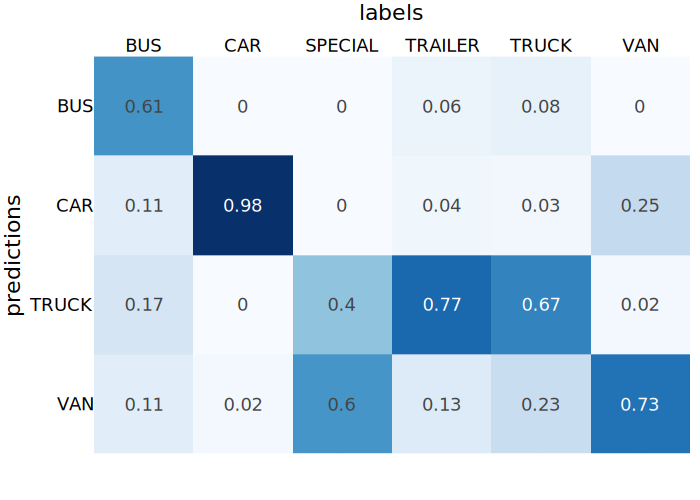

In [11]:
# Confusion matrix for category from labels to predictions

model_name = 'coco_yolact_resnet101_edge'

matches_df = matches_dfs[model_name]

confusion_df = pd.crosstab(
    matches_df.prediction_category,
    np.array([c.split('_')[0] for c in matches_df.label_category]),
    normalize='columns',
    rownames=['predictions'],
    colnames=['labels'],
)
fig = px.imshow(confusion_df.round(2), text_auto=True, color_continuous_scale='blues')
fig.update_layout(coloraxis_showscale=False, xaxis_side='top', font_size=18, margin_b=0)
fig.write_image(os.path.join(output_dir, 'confusion.pdf'))
fig.show('svg')

In [26]:
# Number of matched vehicles per labeled category

matches_df.label_category.value_counts()

CAR                2592
VAN                 347
TRAILER             170
TRUCK               117
BUS                  18
SPECIAL_VEHICLE       5
Name: label_category, dtype: int64

In [27]:
# Number of matched vehicles per predicted category

matches_df.prediction_category.value_counts()

CAR      2642
VAN       353
TRUCK     223
BUS        31
Name: prediction_category, dtype: int64

In [21]:
# MAE values per label category

error_columns = [
    'x_error',
    'y_error',
    'z_error',
    'length_error',
    'width_error',
    'height_error',
]

matches_df[error_columns].abs().groupby(matches_df.label_category).mean().round(2)


x_error  y_error  z_error  length_error  width_error  \
label_category                                                          
BUS                16.83     0.51      0.0          3.79         0.21   
CAR                 1.22     0.19      0.0          0.48         0.22   
SPECIAL_VEHICLE     2.56     0.32      0.0          5.15         0.37   
TRAILER             2.99     0.43      0.0          4.53         0.38   
TRUCK               4.75     0.42      0.0          7.82         0.35   
VAN                 2.14     0.29      0.0          1.65         0.35   

                 height_error  
label_category                 
BUS                      0.41  
CAR                      0.10  
SPECIAL_VEHICLE          0.10  
TRAILER                  0.23  
TRUCK                    0.36  
VAN                      0.14

In [24]:
# One very large outlier for a small number of busses influences the mean heavily.

matches_df[matches_df.label_category == 'BUS'].x_error.sort_values(ascending=False)

3148    226.960532
1272      7.608029
978       4.976346
1592      4.573476
2898      4.223742
3029      1.659039
1785      1.404579
2822      1.286814
2503      1.203059
2434      1.053015
2744      0.813185
86        0.300501
2645     -0.335199
424      -0.451211
2127     -3.364077
433      -5.071812
2534     -8.196719
1599    -29.509190
Name: x_error, dtype: float64

In [13]:
# MAE values per camera

matches_df[error_columns].abs().groupby(matches_df.camera).mean().round(2)

x_error  y_error  z_error  length_error  width_error  \
camera                                                                 
s40-north-16mm     1.46     0.27      0.0          1.31         0.24   
s40-north-50mm     1.59     0.21      0.0          0.90         0.27   
s50-south-16mm     1.36     0.20      0.0          1.32         0.30   
s50-south-50mm     1.85     0.20      0.0          1.07         0.22   

                height_error  
camera                        
s40-north-16mm          0.16  
s40-north-50mm          0.11  
s50-south-16mm          0.15  
s50-south-50mm          0.09

In [14]:
# MAE values per camera and distance

distance_intervals = 25 * (matches_df.camera_distance // 25)
distance_df = (
    matches_df[['x_error', 'y_error', 'length_error', 'width_error', 'height_error']]
    .abs()
    .groupby([matches_df.camera, distance_intervals])
    .mean()
    .round(2)
)
distance_df

x_error  y_error  length_error  width_error  \
camera         camera_distance                                                
s40-north-16mm 0.0                 0.42     0.11          0.77         0.16   
               25.0                0.60     0.17          0.77         0.25   
               50.0                1.12     0.27          1.46         0.24   
               75.0                1.79     0.28          1.45         0.26   
               100.0               2.02     0.33          1.35         0.23   
s40-north-50mm 50.0                0.97     0.17          0.50         0.25   
               75.0                0.58     0.11          0.70         0.27   
               100.0               0.86     0.12          0.74         0.23   
               125.0               1.96     0.20          1.07         0.27   
               150.0               1.41     0.18          0.96         0.28   
               175.0               1.45     0.23          0.89         0.26   
               200.0               1.73     0.25          1.08         0.27   
               225.0               2.30     0.28          0.77         0.26   
s50-south-16mm 0.0                 0.47     0.13          1.10         0.34   
               25.0                0.73     0.14          0.92         0.32   
               50.0                0.88     0.18          1.26         0.31   
               75.0                1.57     0.23          1.41         0.29   
               100.0               1.90     0.22          1.50         0.29   
s50-south-50mm 50.0                0.53     0.10          0.48         0.14   
               75.0                0.73     0.16          0.59         0.19   
               100.0               0.83     0.17          0.69         0.19   
               125.0               1.02     0.19          0.68         0.19   
               150.0               1.26     0.16          1.05         0.23   
               175.0               1.71     0.18          1.02         0.23   
               200.0               2.76     0.26          1.51         0.23   
               225.0               3.52     0.27          1.48         0.23   

                                height_error  
camera         camera_distance                
s40-north-16mm 0.0                      0.16  
               25.0                     0.13  
               50.0                     0.15  
               75.0                     0.15  
               100.0                    0.19  
s40-north-50mm 50.0                     0.07  
               75.0                     0.07  
               100.0                    0.09  
               125.0                    0.11  
               150.0                    0.10  
               175.0                    0.11  
               200.0                    0.12  
               225.0                    0.13  
s50-south-16mm 0.0                      0.48  
               25.0                     0.19  
               50.0                     0.11  
               75.0                     0.12  
               100.0                    0.18  
s50-south-50mm 50.0                     0.06  
               75.0                     0.06  
               100.0                    0.06  
               125.0                    0.06  
               150.0                    0.09  
               175.0                    0.09  
               200.0                    0.11  
               225.0                    0.12

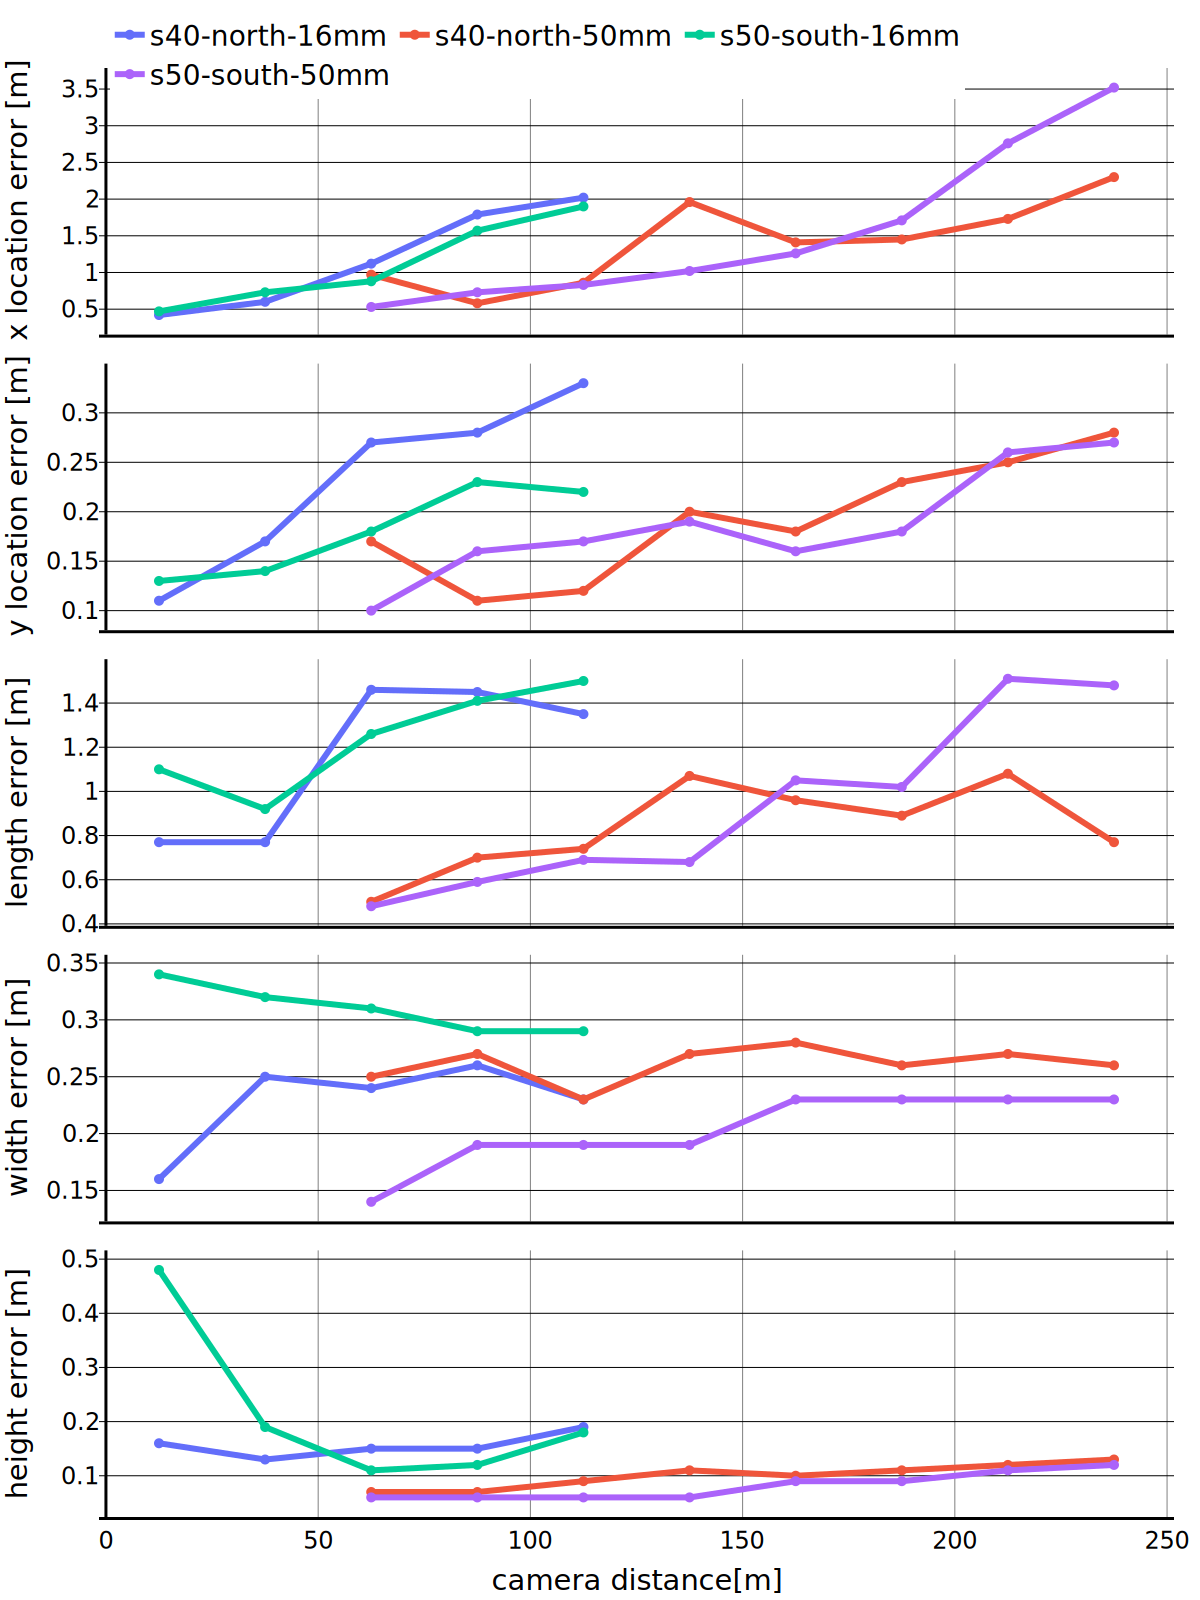

In [28]:
# Figure for MAE values per camera and distance

fig = make_subplots(5, 1, shared_xaxes=True, vertical_spacing=0.02)
fig.update_layout(
    width=1200,
    height=1600,
    font_size=24,
    legend=dict(
        x=0.01,
        y=1.04,
        orientation='h',
        font=dict(size=28),
    ),
)


df = distance_df.reset_index()
df.camera_distance += 12.5


for i, camera in enumerate(df.camera.unique()):
    for j, (name, values) in enumerate(distance_df.loc[camera].iteritems()):
        fig.add_scatter(
            y=values,
            x=values.index + 12.5,
            row=j + 1,
            col=1,
            showlegend=j == 0,
            name=camera,
            line_color=px.colors.qualitative.Plotly[i],
            line_width=6,
            marker_size=10,
        )

y_titles = [
    'x location error [m]',
    'y location error [m]',
    'length error [m]',
    'width error [m]',
    'height error [m]',
]

for i in range(1, 6):
    fig.update_layout(
        **{
            f'xaxis{i}': dict(
                zerolinecolor='black',
                linecolor='black',
                linewidth=3,
                zerolinewidth=3,
                gridcolor='grey',
            ),
            f'yaxis{i}': dict(gridcolor='black', title=y_titles[i - 1]),
        }
    )

fig.update_layout(xaxis5=dict(title='camera distance[m]'))


fig.write_image(os.path.join(output_dir, 'errors_distance.pdf'))

fig.show('svg')

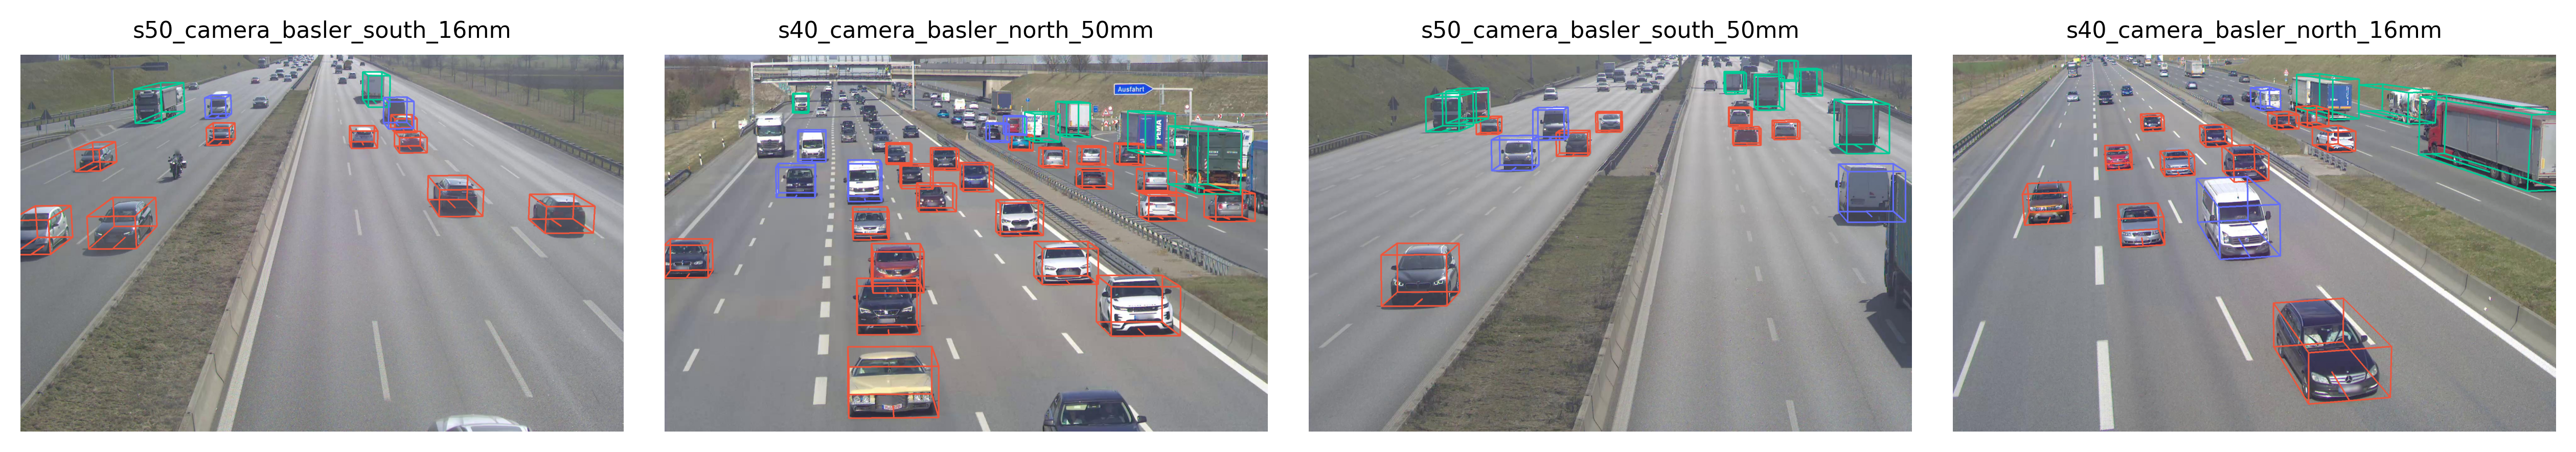

In [16]:
# Qualitative results

# s40 50mm, s40 50mm, s50 16mm, s40 16mm
indices = [640, 364, 460, 416]

color_mapping = {
    category: color
    for category, color in zip(
        dimension_values_mapping.keys(), px.colors.qualitative.Plotly
    )
}

frames = {}

thresholds, vertical_contour_shift = best_parameters[model_name]
for frame, detections, (_, labels_data) in zip(
    frame_loader.load_items(indices),
    detections_loaders[model_name].load_items(indices),
    labels_loader.load_items(indices),
):
    perspective = match_perspective(perspectives, labels_data)
    camera = extract_camera_name(labels_data)

    predictions = create_predictions(
        detections,
        perspective,
        direction_line,
        {**thresholds, 'mask_width': 50},
        vertical_contour_shift,
        label_mappings['coco'],
        dimension_values_mapping,
    )

    frames[camera] = viz.overlay_3d_vehicles(
        frame,
        predictions,
        perspective,
        box_colors=[color_mapping[vehicle.category] for vehicle in predictions],
        box_thickness=4,
    )

fig = plt.figure(figsize=(16, 3), dpi=400)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)
for ax, (camera, img) in zip(grid, frames.items()):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(camera, {'fontsize': 8})
plt.show()

for camera, img in frames.items():
    plt.imsave(os.path.join(output_dir, camera + '.png'), img)